# Documentation

**Author:** Anirudh  
**Date:** 09/04/2025  

### Modification Details:
- **Model Change:** Replacing Linear Mixed Models (LMM) with Ordinary Least Squares (OLS).
- **Predictors Update:** Including each sleep variable, ICV, Gender, and other relevant variables as predictors.
- **Outcome Update:** Separating outcomes into two categories:
    - MRI variables.
    - Cognitive test variables.
- **Variables change:** Replacing Adjusted Age to AGE
- **Additional changes:** Changing the groupby function for the OLS results (instead of grouping by Outcome and feature, grouped by model)
    - Added model name = outcome + feature
    - Changed the formula to have sleep variable + features instead of features + sleep variable
    - ICV is irrelevant to cognitive outcomes, so removed it for the cognitive outcomes
    - Instead of normalizing for ICV, using ICV as covariate instead
    - Check for the insomnia categorization
    - Added Diagnoses and changed formula to have sleep variable + features instead of features + sleep variable

In [38]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [39]:
merge = pd.read_csv("Latest_all_in_one.csv")
merge.head()

,RID,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,RightEntorhinal,RightTemporalPole,RightParahippocampal,RightInferiorTemporal,RightMiddleTemporal,...,Adjusted_Age,MH,NPIK,NPIKSEV,BMI,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2
0,3,0,0,0,0,791.846918,1078.037276,1512.146246,6716.630454,8350.166431,...,81.300000,1,0.0,0.0,10.927769,-1.021,-1.144,-0.880,-1.368,-1.062
1,3,0,0,0,0,958.133790,938.695742,1614.977833,6975.019609,7541.152761,...,81.798289,1,0.0,0.0,10.927769,-1.187,-0.674,-1.221,-1.638,-0.670
2,3,0,0,0,0,676.398197,1094.889167,1440.387527,6116.780815,7896.178469,...,82.299316,1,0.0,0.0,10.927769,-0.914,-0.969,-0.548,-1.837,-1.034
3,3,0,0,0,0,442.103700,1037.524095,1379.850263,6111.576649,7557.134067,...,83.298630,1,0.0,0.0,10.927769,-1.369,-1.511,0.739,-1.700,-1.605
4,5,0,0,0,0,2376.161479,1881.167048,2169.129587,9288.203483,10896.464856,...,73.700000,0,0.0,0.0,12.273373,0.743,0.165,0.739,0.259,-0.152


In [40]:
merge.columns.to_list()

['RID',
 'Sleep_Apnea',
 'Restless_Legs',
 'Insomnia',
 'Sleep_Disturbance_Other',
 'RightEntorhinal',
 'RightTemporalPole',
 'RightParahippocampal',
 'RightInferiorTemporal',
 'RightMiddleTemporal',
 'RightFusiform',
 'RightInferiorParietal',
 'RightIsthmusCingulate',
 'RightBankssts',
 'RightPrecuneus',
 'RightHippocampus',
 'RightAmygdala',
 'RightAccumbensArea',
 'RightMedialOrbitofrontal',
 'RightPallidum',
 'RightCaudalMiddleFrontal',
 'RightPutamen',
 'RightRostralAnteriorCingulate',
 'RightParacentral',
 'RightPrecentral',
 'RightLingual',
 'LeftEntorhinal',
 'LeftHippocampus',
 'LeftFusiform',
 'LeftMiddleTemporal',
 'LeftParacentral',
 'RightInferiorLateralVentricle',
 'LeftInferiorLateralVentricle',
 'RightLateralVentricle',
 'LeftLateralVentricle',
 'VISCODE',
 'DX',
 'DX_bl',
 'PTGENDER',
 'PTEDUCAT',
 'PTETHCAT',
 'PTRACCAT',
 'PTMARRY',
 'APOE4',
 'Adjusted_Age',
 'MH',
 'NPIK',
 'NPIKSEV',
 'BMI',
 'ADNI_MEM',
 'ADNI_EF',
 'ADNI_VS',
 'ADNI_LAN',
 'ADNI_EF2']

In [41]:
sleep_cols = ['Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
merge['MHSleep'] = merge[sleep_cols].sum(axis=1)

In [42]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'MHSleep']
mri_vars = [
    "RightEntorhinal",
    "RightTemporalPole",
    "RightParahippocampal",
    "RightInferiorTemporal",
    "RightMiddleTemporal",
    "RightFusiform",
    "RightInferiorParietal",
    "RightIsthmusCingulate",
    "RightBankssts",
    "RightPrecuneus",
    "RightHippocampus",
    "RightAmygdala",
    "RightAccumbensArea",
    "RightMedialOrbitofrontal",
    "RightPallidum",
    "RightCaudalMiddleFrontal",
    "RightPutamen",
    "RightRostralAnteriorCingulate",
    "RightParacentral",
    "RightPrecentral",
    "RightLingual",
    "LeftEntorhinal",
    "LeftHippocampus",
    "LeftFusiform",
    "LeftMiddleTemporal",
    "LeftParacentral",
    "RightInferiorLateralVentricle",
    "LeftInferiorLateralVentricle",
    "RightLateralVentricle",
    "LeftLateralVentricle",
]

In [43]:
merge_scale = merge.copy()

In [44]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in merge_scale.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

for column in sleep_vars:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

In [45]:
label_encoders

{'VISCODE': LabelEncoder(),
 'DX': LabelEncoder(),
 'DX_bl': LabelEncoder(),
 'PTGENDER': LabelEncoder(),
 'PTETHCAT': LabelEncoder(),
 'PTRACCAT': LabelEncoder(),
 'PTMARRY': LabelEncoder(),
 'NPIK': LabelEncoder(),
 'NPIKSEV': LabelEncoder(),
 'MHSleep': LabelEncoder()}

In [46]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes +
    mri_vars + ['BMI', 'Adjusted_Age']
)
scaler = StandardScaler()
merge_scale[continuous_vars] = scaler.fit_transform(
    merge_scale[continuous_vars])

In [47]:
categorical_vars = ['DX', 'PTETHCAT']
merge_scaled = pd.get_dummies(merge_scale, columns=categorical_vars, drop_first=True)

In [48]:
merge_scaled

,RID,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,RightEntorhinal,RightTemporalPole,RightParahippocampal,RightInferiorTemporal,RightMiddleTemporal,...,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2,MHSleep,DX_1,DX_2,PTETHCAT_1,PTETHCAT_2
0,3,0,0,0,0,-1.794976,-1.813615,-0.798255,-1.222265,-0.810502,...,-0.920088,-1.037360,-0.877479,-1.280535,-0.843032,0,True,False,True,False
1,3,0,0,0,0,-1.439588,-2.169884,-0.497923,-1.064186,-1.337238,...,-1.059528,-0.626836,-1.266336,-1.525735,-0.488302,0,True,False,True,False
2,3,0,0,0,0,-2.041713,-1.770527,-1.007836,-1.589244,-1.106086,...,-0.830207,-0.884505,-0.498884,-1.706456,-0.817694,0,True,False,True,False
3,3,0,0,0,0,-2.542446,-1.917199,-1.184642,-1.592428,-1.326832,...,-1.212409,-1.357918,0.968739,-1.582040,-1.334405,0,True,False,True,False
4,5,0,0,0,0,1.591018,0.239835,1.120546,0.350987,0.847352,...,0.561679,0.105993,0.968739,0.197022,-0.019552,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,1425,0,0,0,0,-0.481870,1.286454,-0.698509,0.964193,1.426447,...,-1.457690,-0.979712,0.968739,-2.323997,-0.629470,0,False,True,True,False
2084,1427,0,0,0,0,0.505054,0.891183,0.752836,0.423914,2.041101,...,-0.369885,-1.563180,-1.618703,-0.484997,-1.729857,0,False,True,True,False
2085,1427,0,0,0,0,-0.134925,0.824206,0.626874,0.198416,2.067794,...,-1.276249,-1.472340,-1.941420,-1.527551,-1.500006,0,False,True,True,False
2086,1427,0,0,0,0,0.197096,1.026601,0.596270,0.068768,1.597591,...,-1.544210,-1.457492,-0.622042,-0.897296,-1.734382,0,True,False,True,False


In [49]:
mri_outcomes = mri_vars
cognitive_outcomes = cognitive_outcomes
predictorscog = ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT', 'APOE4', 'DX_1', 'DX_2','PTETHCAT_1', 'PTETHCAT_2','PTRACCAT','PTMARRY']
predictorsmri = ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT', 'APOE4', 'DX_1', 'DX_2', 'PTETHCAT_1', 'PTETHCAT_2','PTRACCAT','PTMARRY']

In [81]:
merge_norm = merge_scaled

In [73]:
OLS_results_cognitive = []
OLS_results_mri = []
model_counter = 1


def store_all_predictors_ols(model, outcome, sleep_var, predictors):
    records = []
    for predictor in predictors + [sleep_var]:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': model.params.get(predictor, float('nan')),
            'P-Value': model.pvalues.get(predictor, float('nan')),
            'R-Squared': model.rsquared
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorscog)}"
            model = smf.ols(formula, data=merge_norm).fit()

            records = store_all_predictors_ols(
                model, outcome, sleep_var, predictorscog)
            OLS_results_cognitive.extend(records)
            model_counter += 1
        except Exception as e:
            print(f"[OLS Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorsmri)}"
            model = smf.ols(formula, data=merge_norm).fit()

            records = store_all_predictors_ols(
                model, outcome, sleep_var, predictorsmri)
            OLS_results_mri.extend(records)
            model_counter += 1
        except Exception as e:
            print(f"[OLS MRI] Error for {outcome} with {sleep_var}: {e}")

In [74]:
OLS_results_cognitive_df = pd.DataFrame(OLS_results_cognitive)
OLS_results_mri_df = pd.DataFrame(OLS_results_mri)

In [75]:
OLS_results_cognitive_df 

,Model_ID,Outcome,Sleep_Variable,Feature,Coefficient,P-Value,R-Squared
0,model_1,ADNI_MEM,NPIK,PTGENDER,-0.146506,0.010989,0.573311
1,model_1,ADNI_MEM,NPIK,Adjusted_Age,-0.036304,0.201553,0.573311
2,model_1,ADNI_MEM,NPIK,PTEDUCAT,0.022181,0.021300,0.573311
3,model_1,ADNI_MEM,NPIK,APOE4,-0.084978,0.045541,0.573311
4,model_1,ADNI_MEM,NPIK,DX_1,NaN,NaN,0.573311
...,...,...,...,...,...,...,...
160,model_15,ADNI_EF2,MHSleep,PTETHCAT_1,NaN,NaN,0.417995
161,model_15,ADNI_EF2,MHSleep,PTETHCAT_2,NaN,NaN,0.417995
162,model_15,ADNI_EF2,MHSleep,PTRACCAT,0.025527,0.799596,0.417995
163,model_15,ADNI_EF2,MHSleep,PTMARRY,0.007140,0.829493,0.417995


In [76]:
flat_cog = OLS_results_cognitive_df[~OLS_results_cognitive_df['Feature'].isin(
    ['Intercept', 'Group Var'])]
flat_mri = OLS_results_mri_df[~OLS_results_mri_df['Feature'].isin(
    ['Intercept', 'Group Var'])]

In [77]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT': 'Race',
    'PTETHCAT_1': 'Not Hisp/Latino',
    'PTETHCAT_2': 'Unknown Eth'
}

In [78]:
flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)

In [ ]:
import math


import math
import seaborn as sns
import matplotlib.pyplot as plt


def plot_ols_coefficients_grid(df, domain='Cognitive', n_cols=2, alpha=0.05):
    sleep_vars = df['Sleep_Variable'].unique()
    n_plots = len(sleep_vars)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5), squeeze=False)

    for idx, sleep_var in enumerate(sleep_vars):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        df_plot = df[df['Sleep_Variable'] == sleep_var]
        sleep_feat = sleep_var
        df_others = df_plot[df_plot['Feature'] != sleep_feat]
        sns.barplot(
            data=df_others,
            x='Coefficient',
            y='Outcome',
            hue='Feature',
            dodge=True,
            palette='tab10',
            ax=ax,
            alpha=0.7
        )
        df_sleep = df_plot[df_plot['Feature'] == sleep_feat]
        if not df_sleep.empty:
            sns.barplot(
                data=df_sleep,
                x='Coefficient',
                y='Outcome',
                color='crimson',
                ax=ax,
                label=sleep_feat,
                dodge=True,
                alpha=0.5,
                linewidth=2,
                edgecolor='black'
            )

        ax.axvline(x=0, color='red', linestyle='--', label='Zero')

        sig_coefs = df_plot[df_plot['P-Value'] <= alpha]['Coefficient'].dropna()
        if not sig_coefs.empty:
            threshold = sig_coefs.abs().min()  
            ax.axvline(x=threshold, color='green', linestyle=':', label=f'p < {alpha}')
            ax.axvline(x=-threshold, color='green', linestyle=':')

        ax.set_title(f'{sleep_var}', fontsize=12)
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Outcome')
        ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels[:-1], bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.legend([handles[-1]], ['Sleep-Variable'], title='Predictor', bbox_to_anchor=(1.02, 1.05), loc='upper left')

    fig.suptitle(f'Lasso Coefficients: Sleep Variables on {domain} Outcomes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 0.97])
    plt.show()


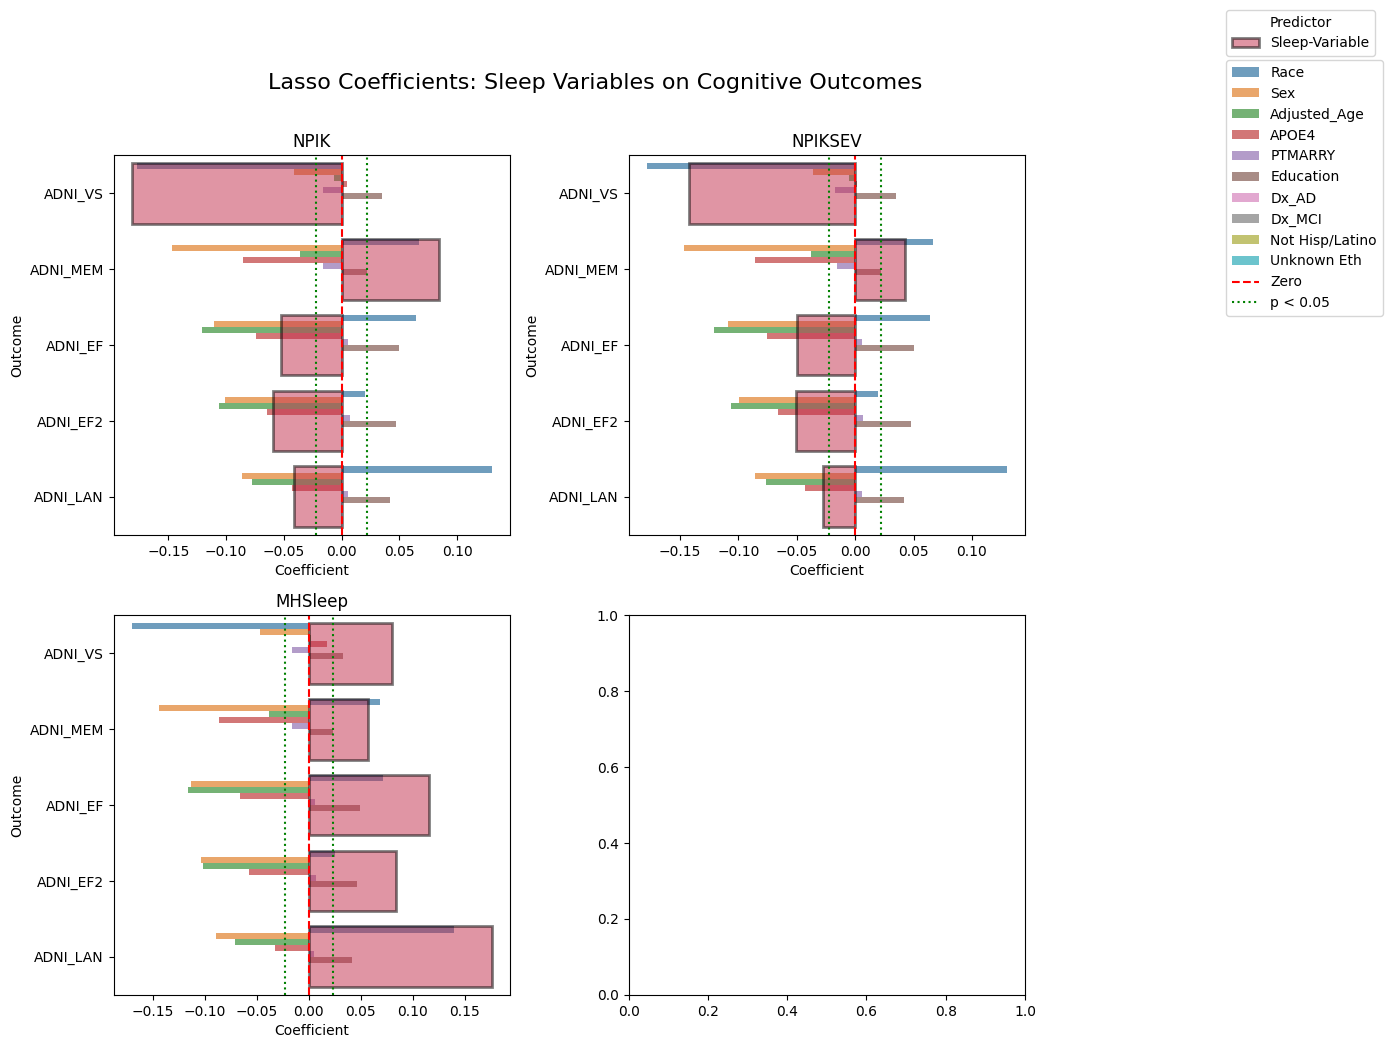

In [83]:
plot_ols_coefficients_grid(flat_cog.sort_values(
    by='Coefficient'), domain='Cognitive')

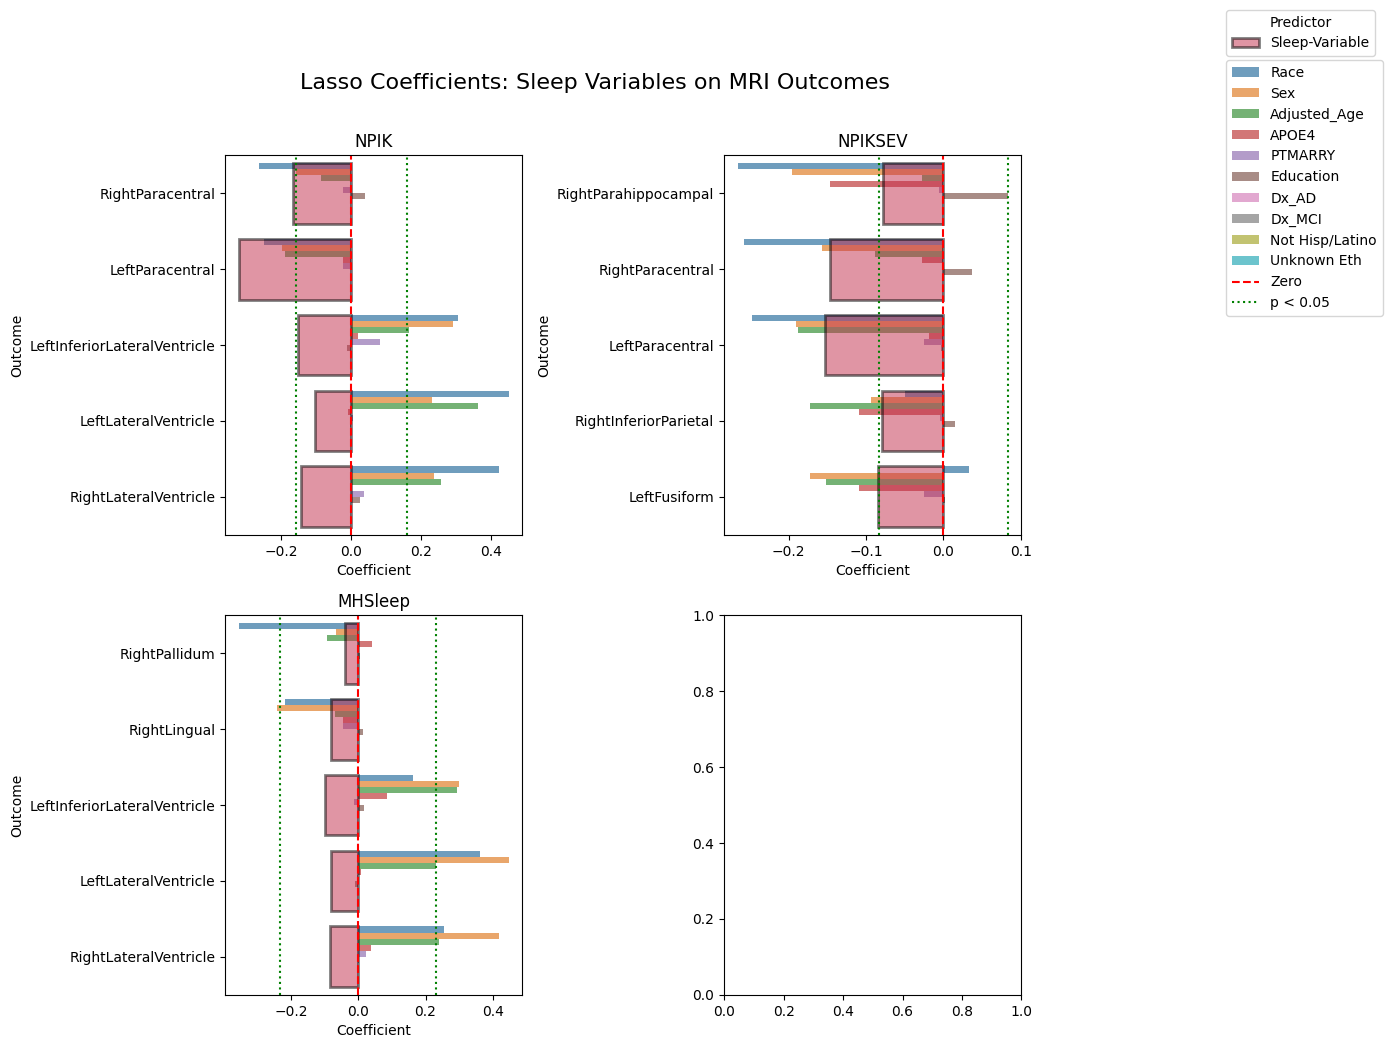

In [84]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Variable'].unique():
    df_plot = flat_mri[(flat_mri['Sleep_Variable'] == sleep_var)]

    top_outcomes = (
        df_plot[(df_plot['Feature'] == sleep_var) ]
        .sort_values(by='Coefficient')
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(5)
        .index
    )
    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top.sort_values(by='Coefficient'))

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_ols_coefficients_grid(df_top_all, domain='MRI')

# Tables

In [60]:
flat_cog.sort_values(by='P-Value',inplace=True)

In [61]:
summary_rows = []

for sleep_var in flat_cog['Sleep_Variable'].unique():
    for outcome in flat_cog['Outcome'].unique():
        subset = flat_cog[
            (flat_cog['Sleep_Variable'] == sleep_var) &
            (flat_cog['Outcome'] == outcome)
        ]

        if subset.empty:
            continue
        top_neg = subset.nsmallest(3, 'Coefficient')
        for _, row in top_neg.iterrows():
            summary_rows.append({
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Direction': 'Most Negative',
                'Feature': row['Feature'],
                'Coefficient': row['Coefficient'],
                'P-Value': row['P-Value'],
                'R-Squared': row['R-Squared']
            })
        top_pos = subset.nlargest(3, 'Coefficient')
        for _, row in top_pos.iterrows():
            summary_rows.append({
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Direction': 'Most Positive',
                'Feature': row['Feature'],
                'Coefficient': row['Coefficient'],
                'P-Value': row['P-Value'],
                'R-Squared': row['R-Squared']
            })

cog_summary_df = pd.DataFrame(summary_rows)
cog_summary_df = cog_summary_df.sort_values(
    by=['Outcome', 'Sleep_Variable', 'Direction'])

In [62]:
cog_summary_df

,Sleep_Variable,Outcome,Direction,Feature,Coefficient,P-Value,R-Squared
60,MHSleep,ADNI_EF,Most Negative,Adjusted_Age,-0.078345,0.032468,0.533562
61,MHSleep,ADNI_EF,Most Negative,Sex,-0.075448,0.309366,0.533562
62,MHSleep,ADNI_EF,Most Negative,APOE4,-0.069247,0.212683,0.533562
63,MHSleep,ADNI_EF,Most Positive,MHSleep,0.113252,0.170451,0.533562
64,MHSleep,ADNI_EF,Most Positive,Education,0.048317,0.000128,0.533562
...,...,...,...,...,...,...,...
49,NPIKSEV,ADNI_VS,Most Negative,APOE4,-0.034821,0.604229,0.274330
50,NPIKSEV,ADNI_VS,Most Negative,Sex,-0.004293,0.962021,0.274330
51,NPIKSEV,ADNI_VS,Most Positive,Adjusted_Age,0.084470,0.056423,0.274330
52,NPIKSEV,ADNI_VS,Most Positive,Education,0.050190,0.000995,0.274330


In [63]:
formatted_df = cog_summary_df.copy()

formatted_df['Effect (p)'] = formatted_df.apply(
    lambda row: f"{row['Coefficient']:.2f} (p={abs(row['P-Value']):.2g})", axis=1
)
final_df = formatted_df[['Sleep_Variable', 'Outcome',
                         'Direction', 'Feature', 'Effect (p)', 'R-Squared']]
final_df = final_df.sort_values(by=['Sleep_Variable', 'Outcome', 'Direction'])

In [64]:
final_df

,Sleep_Variable,Outcome,Direction,Feature,Effect (p),R-Squared
60,MHSleep,ADNI_EF,Most Negative,Adjusted_Age,-0.08 (p=0.032),0.533562
61,MHSleep,ADNI_EF,Most Negative,Sex,-0.08 (p=0.31),0.533562
62,MHSleep,ADNI_EF,Most Negative,APOE4,-0.07 (p=0.21),0.533562
63,MHSleep,ADNI_EF,Most Positive,MHSleep,0.11 (p=0.17),0.533562
64,MHSleep,ADNI_EF,Most Positive,Education,0.05 (p=0.00013),0.533562
...,...,...,...,...,...,...
49,NPIKSEV,ADNI_VS,Most Negative,APOE4,-0.03 (p=0.6),0.274330
50,NPIKSEV,ADNI_VS,Most Negative,Sex,-0.00 (p=0.96),0.274330
51,NPIKSEV,ADNI_VS,Most Positive,Adjusted_Age,0.08 (p=0.056),0.274330
52,NPIKSEV,ADNI_VS,Most Positive,Education,0.05 (p=0.001),0.274330


In [65]:
flat_cog_self = flat_cog[flat_cog['Feature'] == flat_cog['Sleep_Variable']]

pivot_df = flat_cog_self.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)
for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f}){'*' if row[pval_col] < 0.05 else ''}"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""
final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"

In [66]:
final_df

,Outcome,NPIK,NPIKSEV,MHSleep
Cognitive Outcome,,,,
0,ADNI_EF,-0.20 (p=0.04)*,-0.10 (p=0.08),0.11 (p=0.17)
1,ADNI_EF2,-0.20 (p=0.04)*,-0.08 (p=0.14),0.11 (p=0.20)
2,ADNI_LAN,-0.30 (p=0.00)*,-0.20 (p=0.00)*,0.17 (p=0.05)
3,ADNI_MEM,-0.09 (p=0.28),-0.07 (p=0.13),0.09 (p=0.19)
4,ADNI_VS,-0.27 (p=0.02)*,-0.19 (p=0.01)*,0.08 (p=0.45)


In [67]:
pivot_df = flat_mri.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f}){'*' if row[pval_col] < 0.05 else ''}"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"

In [68]:
final_df

,Outcome,NPIK,NPIKSEV,MHSleep
Cognitive Outcome,,,,
0,LeftEntorhinal,0.10 (p=0.19),0.10 (p=0.20),0.10 (p=0.18)
1,LeftFusiform,0.06 (p=0.50),0.07 (p=0.45),0.05 (p=0.56)
2,LeftHippocampus,-0.08 (p=0.29),-0.07 (p=0.31),-0.07 (p=0.29)
3,LeftInferiorLateralVentricle,0.30 (p=0.00)*,0.29 (p=0.00)*,0.31 (p=0.00)*
4,LeftLateralVentricle,0.48 (p=0.00)*,0.47 (p=0.00)*,0.48 (p=0.00)*
5,LeftMiddleTemporal,0.09 (p=0.29),0.10 (p=0.24),0.08 (p=0.33)
6,LeftParacentral,-0.23 (p=0.01)*,-0.22 (p=0.02)*,-0.24 (p=0.01)*
7,RightAccumbensArea,-0.15 (p=0.09),-0.14 (p=0.10),-0.15 (p=0.09)
8,RightAmygdala,0.26 (p=0.00)*,0.26 (p=0.00)*,0.27 (p=0.00)*


In [69]:
final_df_sorted = final_df.copy()
for col in final_df.columns[1:]:
    final_df_sorted[col] = final_df_sorted[col].sort_values(ignore_index=True)
final_df_sorted

,Outcome,NPIK,NPIKSEV,MHSleep
Cognitive Outcome,,,,
0,LeftEntorhinal,-0.03 (p=0.76),-0.03 (p=0.77),-0.03 (p=0.76)
1,LeftFusiform,-0.04 (p=0.68),-0.04 (p=0.69),-0.04 (p=0.68)
2,LeftHippocampus,-0.08 (p=0.29),-0.07 (p=0.31),-0.07 (p=0.29)
3,LeftInferiorLateralVentricle,-0.13 (p=0.07),-0.13 (p=0.07),-0.12 (p=0.08)
4,LeftLateralVentricle,-0.15 (p=0.09),-0.14 (p=0.10),-0.15 (p=0.09)
5,LeftMiddleTemporal,-0.20 (p=0.03)*,-0.19 (p=0.04)*,-0.20 (p=0.03)*
6,LeftParacentral,-0.20 (p=0.03)*,-0.20 (p=0.03)*,-0.20 (p=0.03)*
7,RightAccumbensArea,-0.21 (p=0.02)*,-0.21 (p=0.02)*,-0.21 (p=0.02)*
8,RightAmygdala,-0.23 (p=0.01)*,-0.22 (p=0.02)*,-0.24 (p=0.00)*


In [85]:
def extract_coef(value):
    try:
        return float(value.split(" (")[0])
    except:
        return None


for col in ['NPIK', 'NPIKSEV', 'MHSleep']:
    final_df_sorted[f'{col}_coef'] = final_df_sorted[col].apply(extract_coef)

summary_rows = []
for col in ['NPIK', 'NPIKSEV', 'MHSleep']:
    top_pos = final_df_sorted.nlargest(3, f'{col}_coef')[['Outcome', col]]
    top_neg = final_df_sorted.nsmallest(3, f'{col}_coef')[['Outcome', col]]

    for i, row in top_neg.iterrows():
        summary_rows.append({'Column': col, 'Direction': 'Most Negative',
                            'Outcome': row['Outcome'], 'Value': row[col]})
    for i, row in top_pos.iterrows():
        summary_rows.append({'Column': col, 'Direction': 'Most Positive',
                            'Outcome': row['Outcome'], 'Value': row[col]})

summary_df = pd.DataFrame(summary_rows)

In [71]:
summary_df

,Column,Direction,Outcome,Value
0,NPIK,Most Negative,RightInferiorParietal,-0.37 (p=0.00)*
1,NPIK,Most Negative,RightInferiorLateralVentricle,-0.34 (p=0.00)*
2,NPIK,Most Negative,RightHippocampus,-0.32 (p=0.00)*
3,NPIK,Most Positive,RightTemporalPole,0.48 (p=0.00)*
4,NPIK,Most Positive,RightRostralAnteriorCingulate,0.44 (p=0.00)*
5,NPIK,Most Positive,RightPutamen,0.34 (p=0.00)*
6,NPIKSEV,Most Negative,RightInferiorParietal,-0.36 (p=0.00)*
7,NPIKSEV,Most Negative,RightInferiorLateralVentricle,-0.34 (p=0.00)*
8,NPIKSEV,Most Negative,RightHippocampus,-0.32 (p=0.00)*
9,NPIKSEV,Most Positive,RightTemporalPole,0.47 (p=0.00)*
